# 5 Making the VIDEO reference catalogues


Here we will make a video set of reference catalogues. These reference catalogues have been through many iterations.

First we calibrated against 2MASS with colour terms. We later decided to calibrate against the official VISTA catalogues.

The current decision is to calibrate each catalogue to its CASU latest release. One exception to this is the VIDEO SXDS field where we use VHS for the JHKs bands and VIDEO for the ZY bands. This was done because teh latest VIDEO release is missing some J coverage and also because we would like VHS and VIKING to be on the same photometric solution.

In [1]:
# What version of the Stack are we using?
! eups list -s | grep lsst_distrib
! eups list -s | grep obs_vista

lsst_distrib          g2d4714e03a+6e1aa0b536 	current w_latest w_2022_07 setup
obs_vista             23.0.0-1   	current setup


In [2]:
from lsst.meas.algorithms.htmIndexer import HtmIndexer
from lsst.geom import SpherePoint 
from lsst.geom import degrees
from lsst.afw.image import abMagErrFromFluxErr, abMagFromFlux,fluxFromABMag,fluxErrFromABMagErr

import numpy as np
from astropy.io import fits
import astropy.units as u
from astropy.table import Table
from astropy.time import Time

import matplotlib.pyplot as plt
from collections import OrderedDict

import glob
import warnings
warnings.filterwarnings('ignore')

In [3]:

PS_CATS = "../dmu0/dmu0_PanStarrs/data/ps1_pv3_3pi_20170110/"
PS_CATS19 = "../dmu0/dmu0_PanStarrs/data/ps1_pv3_3pi_20170110_GmagLT19/"
EX_CAT = "../dmu0/dmu0_PanStarrs/data/ps1_pv3_3pi_20170110/149504.fits"
EX_MS = "../dmu0/dmu0_PanStarrs/data/ps1_pv3_3pi_20170110/master_schema.fits"
MASS_CAT = '../dmu0/dmu0_2MASS/data/fp_2mass.fp_psc_29182.tbl'

version = 'DR5' #HELP or DR5

VHS_CAT='../dmu0/dmu0_VISTA/dmu0_VHS/data/VHS_DR6_HSCW02_XMM.fits.gz'
VIDEO_CAT = '../dmu0/dmu0_VISTA/dmu0_VIDEO/data/vista_video_sxds_vsa.fits'
#Private HELP catalogue for comparison (Aperture fluxes not curve of growth corrected)
HELP_CAT='../dmu0/dmu0_VISTA/dmu0_VIDEO/data/VIDEO-all_2017-02-12_fullcat_errfix_v2_XMM-LSS.fits'

In [4]:
help_cat= Table.read(HELP_CAT)

In [5]:
t = Table.read(EX_CAT)

In [6]:
t[:5]

id,coord_ra,coord_dec,parent,g_flux,r_flux,i_flux,z_flux,y_flux,i_fluxSigma,y_fluxSigma,r_fluxSigma,z_fluxSigma,g_fluxSigma,coord_ra_err,coord_dec_err,epoch,pm_ra,pm_dec,pm_ra_err,pm_dec_err,footprint
,rad,rad,,,,,,,,,,,,,,,,,,,
int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,int64,float32,float32,float32,float32,int32
108001343677810453,2.345157026052713,-2.197806797133154e-06,0,1.2838545444537885e-06,1.982928552024532e-06,3.01517138723284e-06,4.856765372096561e-06,--,3.16738379524395e-07,--,3.629729121712444e-07,6.778826104891778e-07,3.0207684176275507e-07,0.0,0.0,1352273536,0.0,0.0,--,--,0
107431343969222916,2.345668457159465,-0.008254100378585155,0,2.007697275985265e-06,6.753069555998081e-06,1.0589669727778528e-05,1.3312220289662946e-05,2.0085879441467114e-05,5.399208475864725e-07,1.157883389169001e-06,2.962838152598124e-07,8.916217097976187e-07,3.1140803002926987e-07,0.0,0.0,1382995072,-0.0027053282,-0.023891896,0.02118348,0.02677908,0
107431343984200158,2.3456946572799193,-0.00829510768268888,0,1.884587049971742e-06,1.9010004734809627e-06,5.857659289176809e-06,8.112950126815122e-06,1.4951265256968327e-05,4.4494140638562385e-07,4.663308175167913e-07,3.0984475074546936e-07,8.782833447185112e-07,2.2170280544742127e-07,0.0,0.0,1361532032,0.07990709,-0.026615456,0.05336448,0.05336448,0
107421343990936666,2.3457072730123314,-0.008344109830567992,0,2.2955191525397822e-06,2.086113454424776e-06,5.038442850491265e-06,7.44710359867895e-06,6.868632681289455e-06,5.957058419880923e-07,1.8847487126549822e-06,2.7256422185928386e-07,5.382827339417418e-07,4.3324499188202026e-07,0.0,0.0,1393959168,-0.096279256,0.0021780662,0.070748076,0.070748076,0
107421344000032859,2.3457229088949574,-0.008399620795089824,0,2.650166607054416e-06,6.488172857643804e-06,9.41978669288801e-06,9.571983355272096e-06,1.6619222151348367e-05,4.193618394765508e-07,1.5774568282722612e-06,3.543551656548516e-07,5.85423322263523e-07,3.2145266004590667e-07,0.0,0.0,1380634624,-0.010534531,0.019350564,0.040031154,0.026171627,0


In [7]:
def getShards(ra, dec, radius):
    htm = HtmIndexer(depth=7)
    shards, onBoundary = htm.getShardIds(SpherePoint(ra*degrees, dec*degrees), radius*degrees)
    return shards
s = getShards(35.428,  -4.90777, 3.0)
s

array([133188, 133200, 133201, 133202, 133203, 133204, 133205, 133206,
       133207, 133208, 133209, 133210, 133211, 133212, 133213, 133214,
       133215, 133234, 133240, 133241, 133243, 133245, 133280, 133281,
       133282, 133283, 133288, 133289, 133291, 133293, 133294, 133295,
       133312, 133313, 133314, 133315, 133316, 133317, 133318, 133319,
       133320, 133321, 133322, 133323, 133324, 133325, 133326, 133327,
       133365, 133368, 133370, 133371, 133372, 133968, 133970, 133971,
       134024, 134048, 134049, 134050, 134051, 134052, 134053, 134054,
       134055, 134057, 134058, 134059, 134060, 134061, 134062, 134063,
       134065, 134068, 134070, 134071, 134078, 134080, 134081, 134083,
       133189, 133190, 133191, 133224, 133232, 133233, 133235, 133242,
       133244, 133246, 133247, 133268, 133285, 133286, 133287, 133290,
       133292, 133296, 133297, 133299, 133336, 133338, 133339, 133348,
       133364, 133366, 133367, 133369, 133373, 133374, 133375, 133969,
      

In [8]:
#Everything in SXDS DUD region
ps_refcats = getShards(36.,  -5.0, 3.0)
files = ''
for c in ps_refcats:
    files += '{}.fits,'.format(c)
print('scp ir-shir1@login.hpc.cam.ac.uk:~/rds/rds-iris-ip005/ras81/lsst-ir-fusion/dmu0/dmu0_PanSTARRS/data/ps1_pv3_3pi_20170110/\{'
      +files[:-1]+'\} ./')

scp ir-shir1@login.hpc.cam.ac.uk:~/rds/rds-iris-ip005/ras81/lsst-ir-fusion/dmu0/dmu0_PanSTARRS/data/ps1_pv3_3pi_20170110/\{133200.fits,133201.fits,133202.fits,133203.fits,133204.fits,133205.fits,133206.fits,133207.fits,133208.fits,133209.fits,133210.fits,133211.fits,133212.fits,133213.fits,133214.fits,133215.fits,133232.fits,133234.fits,133235.fits,133240.fits,133241.fits,133243.fits,133245.fits,133268.fits,133280.fits,133281.fits,133282.fits,133283.fits,133288.fits,133289.fits,133290.fits,133291.fits,133292.fits,133293.fits,133294.fits,133295.fits,133296.fits,133297.fits,133299.fits,133312.fits,133313.fits,133314.fits,133315.fits,133316.fits,133317.fits,133318.fits,133319.fits,133320.fits,133321.fits,133322.fits,133323.fits,133324.fits,133325.fits,133326.fits,133327.fits,133336.fits,133364.fits,133365.fits,133367.fits,133368.fits,133369.fits,133370.fits,133371.fits,133372.fits,133373.fits,133375.fits,133968.fits,134048.fits,134049.fits,134050.fits,134051.fits,134052.fits,134053.fits,1

In [9]:
def clean_table(table):
    """Take a table produced by a VO query and remove all empty columns
    
    Often many columns are empty and make the tables hard to read.
    The function also converts columsn that are objects to strings.
    Object columns prevent writing to fits.
    
    Inputs
    =======
    table,    Astropy.table.Table
        The input table
    
    Returns
    =======
    table,    Astropy.table.Table
         The modified table.
    
    """
    table = table.copy()
    if len(table) == 0:
        return table
    for col in table.colnames:
        #Remove empty columns
        try:
            if np.all(table[col].mask):
                print("Removing empty column: {}".format(col))
                table.remove_column(col)
                continue
        except AttributeError:
            pass
            #print("{} is not a masked columns".format(col))
            
        #Get rid of column type object from VO queries
        if table[col].dtype == 'object':
            print("Converting column {} type from object to string".format(col) )
            table[col] = table[col].astype(str)
 
        #Get rid of unit '-' from some tables
        if table[col].unit == '-':
            print("Converting column {} unit from '-' to None".format(col) )
            table[col].unit = None   
            
        #replace masked floats with nans     
        if (
            (table[col].dtype == float) 
            or (table[col].dtype == 'float32')
            or (table[col].dtype == 'float64')
        ):
            table[col].fill_value = np.nan
    
    table = table.filled()
            
    return table

In [10]:
# Conversion from Vega magnitudes to AB is done using values from 
# http://casu.ast.cam.ac.uk/surveys-projects/vista/technical/filter-set
# additional terms for VISTA to True Vega from Carlos Gonzalez et al.
vega_to_ab = {
    "z":0.502 + 0.004,
    "y":0.600 - 0.022,
    "j":0.916 + 0.0,
    "h":1.366 + 0.019,
    "ks":1.827 - 0.011,
    #"b118":0.853
}

In [11]:
Table.read(VIDEO_CAT).colnames

['SOURCEID',
 'CUEVENTID',
 'FRAMESETID',
 'RA',
 'DEC',
 'CX',
 'CY',
 'CZ',
 'HTMID',
 'L',
 'B',
 'LAMBDA',
 'ETA',
 'PRIORSEC',
 'ZMYPNT',
 'ZMYPNTERR',
 'YMJPNT',
 'YMJPNTERR',
 'JMHPNT',
 'JMHPNTERR',
 'HMKSPNT',
 'HMKSPNTERR',
 'ZMYEXT',
 'ZMYEXTERR',
 'YMJEXT',
 'YMJEXTERR',
 'JMHEXT',
 'JMHEXTERR',
 'HMKSEXT',
 'HMKSEXTERR',
 'MERGEDCLASSSTAT',
 'MERGEDCLASS',
 'PSTAR',
 'PGALAXY',
 'PNOISE',
 'PSATURATED',
 'EBV',
 'AZ',
 'AY',
 'AJ',
 'AH',
 'AKS',
 'ZPETROMAG',
 'ZPETROMAGERR',
 'ZKRONMAG',
 'ZKRONMAGERR',
 'ZAPERMAG3',
 'ZAPERMAG3ERR',
 'ZAPERMAG4',
 'ZAPERMAG4ERR',
 'ZAPERMAG6',
 'ZAPERMAG6ERR',
 'ZAPERMAGNOAPERCORR3',
 'ZAPERMAGNOAPERCORR4',
 'ZAPERMAGNOAPERCORR6',
 'ZHALFRAD',
 'ZHLCORSMJRADAS',
 'ZGAUSIG',
 'ZELL',
 'ZPA',
 'ZERRBITS',
 'ZCLASS',
 'ZCLASSSTAT',
 'ZPPERRBITS',
 'ZSEQNUM',
 'ZXI',
 'ZETA',
 'YPETROMAG',
 'YPETROMAGERR',
 'YKRONMAG',
 'YKRONMAGERR',
 'YAPERMAG3',
 'YAPERMAG3ERR',
 'YAPERMAG4',
 'YAPERMAG4ERR',
 'YAPERMAG6',
 'YAPERMAG6ERR',
 'YAPERMAGNOAP

In [12]:
import logging
LOGGER = logging.getLogger(__name__)
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
from collections import Counter
from astropy.table import Table, Column, hstack, vstack
def merge_catalogues(cat_1, cat_2, racol_2, decol_2, radius=0.4*u.arcsec):
    """Merge two catalogues
    This function merges the second catalogue into the first one using the
    given radius to associate identical sources.  This function takes care to
    associate only one source of one catalogue to the other.  The sources that
    may be associated to various counterparts in the other catalogue are
    flagged as “maybe spurious association” with a true value in the
    flag_merged column.  If this column is present in the first catalogue, it's
    content is “inherited” during the merge.
    Parameters
    ----------
    cat_1: astropy.table.Table
        The table containing the first catalogue.  This is the master catalogue
        used during the merge.  If it has a “flag_merged” column it's content
        will be re-used in the flagging of the spurious merges.  This catalogue
        must contain a ‘ra’ and a ‘dec’ columns with the position in decimal
        degrees.
    cat_2: astropy.table.Table
        The table containing the second catalogue.
    racol_2: string
        Name of the column in the second table containing the right ascension
        in decimal degrees.
    decol_2: string
        Name of the column in the second table containing the declination in
        decimal degrees.
    radius: astropy.units.quantity.Quantity
        The radius to associate identical sources in the two catalogues.
    Returns
    -------
    astropy.table.Table
        The merged catalogue.
    """
    cat_1 = cat_1.copy()
    cat_2 = cat_2.copy()
    cat_1['ra'].unit = u.rad
    cat_1['dec'].unit = u.rad
    coords_1 = SkyCoord(cat_1['ra'], cat_1['dec'])

    
    cat_2[racol_2].unit = u.rad
    cat_2[decol_2].unit = u.rad
    coords_2 = SkyCoord(cat_2[racol_2], cat_2[decol_2])

    # Search for sources in second catalogue matching the sources in the first
    # one.
    idx_2, idx_1, d2d, _ = coords_1.search_around_sky(coords_2, radius)

    # We want to flag the possible mis-associations, i.e. the sources in each
    # catalogue that are associated to several sources in the other one, but
    # also all the sources that are associated to a problematic source in the
    # other catalogue (e.g. if two sources in the first catalogue are
    # associated to the same source in the second catalogue, they must be
    # flagged as potentially problematic).
    #
    # Search for duplicate associations
    toflag_idx_1 = np.unique([item for item, count in Counter(idx_1).items()
                              if count > 1])
    toflag_idx_2 = np.unique([item for item, count in Counter(idx_2).items()
                              if count > 1])
    # Flagging the sources associated to duplicates
    dup_associated_in_idx1 = np.in1d(idx_2, toflag_idx_2)
    dup_associated_in_idx2 = np.in1d(idx_1, toflag_idx_1)
    toflag_idx_1 = np.unique(np.concatenate(
        (toflag_idx_1, idx_1[dup_associated_in_idx1])
    ))
    toflag_idx_2 = np.unique(np.concatenate(
        (toflag_idx_2, idx_2[dup_associated_in_idx2])
    ))

    # Adding the flags to the catalogue.  In the second catalogue, the column
    # is named "flag_merged_2" and will be combined to the flag_merged column
    # one the merge is done.
    try:
        cat_1["flag_merged"] |= np.in1d(np.arange(len(cat_1), dtype=int),
                                        toflag_idx_1)
    except KeyError:
        cat_1.add_column(Column(
            data=np.in1d(np.arange(len(cat_1), dtype=int), toflag_idx_1),
            name="flag_merged"
        ))
    try:
        cat_2["flag_merged_2"] |= np.in1d(np.arange(len(cat_2), dtype=int), toflag_idx_2)
    except KeyError:
        cat_2.add_column(Column(
            data=np.in1d(np.arange(len(cat_2), dtype=int), toflag_idx_2),
            name="flag_merged_2"
        ))


    # Now that we have flagged the maybe spurious associations, we want to
    # associate each source of each catalogue to at most one source in the
    # other one.

    # We sort the indices by the distance to take the nearest counterparts in
    # the following steps.
    sort_idx = np.argsort(d2d)
    idx_1 = idx_1[sort_idx]
    idx_2 = idx_2[sort_idx]

    # These array will contain the indexes of the matching sources in both
    # catalogues.
    match_idx_1 = np.array([], dtype=int)
    match_idx_2 = np.array([], dtype=int)

    while len(idx_1) > 0:

        both_first_idx = np.sort(np.intersect1d(
            np.unique(idx_1, return_index=True)[1],
            np.unique(idx_2, return_index=True)[1],
        ))

        new_match_idx_1 = idx_1[both_first_idx]
        new_match_idx_2 = idx_2[both_first_idx]

        match_idx_1 = np.concatenate((match_idx_1, new_match_idx_1))
        match_idx_2 = np.concatenate((match_idx_2, new_match_idx_2))

        # We remove the matching sources in both catalogues.
        to_remove = (np.in1d(idx_1, new_match_idx_1) |
                     np.in1d(idx_2, new_match_idx_2))
        idx_1 = idx_1[~to_remove]
        idx_2 = idx_2[~to_remove]

    # Indices of un-associated object in both catalogues.
    unmatched_idx_1 = np.delete(np.arange(len(cat_1), dtype=int),match_idx_1)
    unmatched_idx_2 = np.delete(np.arange(len(cat_2), dtype=int),match_idx_2)

    # Sources only in cat_1
    only_in_cat_1 = cat_1[unmatched_idx_1]

    # Sources only in cat_2
    only_in_cat_2 = cat_2[unmatched_idx_2]
    # We are using the ra and dec columns from cat_2 for the position.
    only_in_cat_2[racol_2].name = "ra"
    only_in_cat_2[decol_2].name = "dec"

    # Merged table of sources in both catalogues.
    both_in_cat_1_and_cat_2 = hstack([cat_1[match_idx_1], cat_2[match_idx_2]])
    # We don't need the positions from the second catalogue anymore.
    both_in_cat_1_and_cat_2.remove_columns([racol_2, decol_2])

    # Logging the number of rows
    LOGGER.info("There are %s sources only in the first catalogue",
                len(only_in_cat_1))
    LOGGER.info("There are %s sources only in the second catalogue",
                len(only_in_cat_2))
    LOGGER.info("There are %s sources in both catalogues",
                len(both_in_cat_1_and_cat_2))

    merged_catalogue = vstack([only_in_cat_1, both_in_cat_1_and_cat_2,
                               only_in_cat_2])

    # When vertically stacking the catalogues, some values in the flag columns
    # are masked because they did not exist in the catalogue some row originate
    # from. We must set them to the appropriate value.
    for colname in merged_catalogue.colnames:
        if 'flag' in colname:
            merged_catalogue[colname][merged_catalogue[colname].mask] = False

    # We combined the flag_merged flags
    merged_catalogue['flag_merged'] |= merged_catalogue['flag_merged_2']
    merged_catalogue.remove_column('flag_merged_2')
    merged_catalogue.remove_column('flag_merged')
    return merged_catalogue

In [13]:
#From email from Manda
oxfordApCorr = {
    'HSC_G_2as':0.1765,
    'HSC_G_3as':0.0788,
    'HSC_R_2as':0.1638,
    'HSC_R_3as':0.0905,
    'HSC_I_2as':0.1512,
    'HSC_I_3as':0.0788,
    'HSC_Z_2as':0.2155,
    'HSC_Z_3as':0.1144,
    'HSC_Y_2as':0.2023,
    'HSC_Y_3as':0.1144,
    'VIRCAM_Z_2as':0.3567,
    'VIRCAM_Z_3as':0.2023,
    'VIRCAM_Y_2as':0.3567,
    'VIRCAM_Y_3as':0.2023,
    'VIRCAM_J_2as':0.2980,
    'VIRCAM_J_3as':0.1765,
    'VIRCAM_H_2as':0.2423,
    'VIRCAM_H_3as':0.1512,
    'VIRCAM_Ks_2as':0.2288,
    'VIRCAM_Ks_3as':0.1388}

In [14]:
# Bands: Z,Y,J,H,K 

#Aperture diameter number 2 = 2arcsec
ap=2

imported_columns = OrderedDict({
    'ID': "id",
    'ALPHA_J2000': "ra",
    'DELTA_J2000': "dec",
    'K_CLASS_STAR':  "stellarity",
    'Z_MAG_APER_{}'.format(ap): "m_ap_vista_z2", 
    'Z_MAGERR_APER_{}'.format(ap): "merr_ap_vista_z2",
    'Y_MAG_APER_{}'.format(ap): "m_ap_vista_y2", 
    'Y_MAGERR_APER_{}'.format(ap): "merr_ap_vista_y2",
    'J_MAG_APER_{}'.format(ap): "m_ap_vista_j", 
    'J_MAGERR_APER_{}'.format(ap): "merr_ap_vista_j",        
    'H_MAG_APER_{}'.format(ap): "m_ap_vista_h", 
    'H_MAGERR_APER_{}'.format(ap): "merr_ap_vista_h",        
    'K_MAG_APER_{}'.format(ap): "m_ap_vista_ks", 
    'K_MAGERR_APER_{}'.format(ap): "merr_ap_vista_ks",
})

catalogue = Table.read(HELP_CAT)[list(imported_columns)]
for column in imported_columns:
    new_col = 'help_' + imported_columns[column]
    catalogue[column].name = new_col
    catalogue[new_col].shape=(catalogue[new_col].shape[0],)
    


catalogue['help_ra'].unit = u.deg
catalogue['help_dec'].unit = u.deg

catalogue['help_ra'].convert_unit_to(u.rad)
catalogue['help_dec'].convert_unit_to(u.rad)

for col in catalogue.colnames:
    if col.startswith('video_m_ap'):
        print(col)
        mask = catalogue[col] <= 0
        mask |= catalogue[col] >  30
        catalogue[col][mask] = np.nan
        catalogue[col.replace('video_m', 'video_merr')][mask] = np.nan
        
        
        # Convert magnitude from Vega to AB
#         before = np.nanmean(catalogue[col])
#         catalogue[col] += vega_to_ab[col.split('_')[-1].replace('2', '')]
#         print(col, vega_to_ab[col.split('_')[-1].replace('2', '')], np.nanmean(catalogue[col])-before)
        print('HELP not AB corrected as already AB')
#v_flux = Table.read('../dmu0/dmu0_VISTA/dmu0_VHS/data/VHS_XMM-LSS.fits')
#v_flux = catalogue[catalogue['video_stellarity'] >= 0.9]

catalogue['help_m_ap_vista_z2']-=oxfordApCorr['VIRCAM_Z_{}as'.format(ap)]
catalogue['help_m_ap_vista_y2']-=oxfordApCorr['VIRCAM_Y_{}as'.format(ap)]
catalogue['help_m_ap_vista_j']-=oxfordApCorr['VIRCAM_J_{}as'.format(ap)]
catalogue['help_m_ap_vista_h']-=oxfordApCorr['VIRCAM_H_{}as'.format(ap)]
catalogue['help_m_ap_vista_ks']-=oxfordApCorr['VIRCAM_Ks_{}as'.format(ap)]

help_flux = catalogue

In [15]:
# Bands: Z,Y,J,H,K 


#This is from DR5 public reference (VEGA)
imported_columns = OrderedDict({
    'SOURCEID': "id",
    'RA': "ra",
    'DEC': "dec",
    'PSTAR':  "stellarity",

    'ZAPERMAG3': "m_ap_vista_z2", 
    'ZAPERMAG3ERR': "merr_ap_vista_z2",

    'YAPERMAG3': "m_ap_vista_y2", 
    'YAPERMAG3ERR': "merr_ap_vista_y2",

    'JAPERMAG3': "m_ap_vista_j", 
    'JAPERMAG3ERR': "merr_ap_vista_j",        

    'HAPERMAG3': "m_ap_vista_h", 
    'HAPERMAG3ERR': "merr_ap_vista_h",        

    'KSAPERMAG3': "m_ap_vista_ks", 
    'KSAPERMAG3ERR': "merr_ap_vista_ks",
})

# elif version=='HELP':
#     imported_columns = OrderedDict({
#         'ID': "id",
#         'ALPHA_J2000': "ra",
#         'DELTA_J2000': "dec",
#         'K_CLASS_STAR':  "stellarity",
#         'Z_MAG_APER_3': "m_ap_vista_z2", 
#         'Z_MAGERR_APER_3': "merr_ap_vista_z2",
#         'Y_MAG_APER_3': "m_ap_vista_y2", 
#         'Y_MAGERR_APER_3': "merr_ap_vista_y2",
#         'J_MAG_APER_3': "m_ap_vista_j", 
#         'J_MAGERR_APER_3': "merr_ap_vista_j",        
#         'H_MAG_APER_3': "m_ap_vista_h", 
#         'H_MAGERR_APER_3': "merr_ap_vista_h",        
#         'K_MAG_APER_3': "m_ap_vista_ks", 
#         'K_MAGERR_APER_3': "merr_ap_vista_ks",
#     })

catalogue = Table.read(VIDEO_CAT)[list(imported_columns)]
for column in imported_columns:
    new_col = 'video_' + imported_columns[column]
    catalogue[column].name = new_col
    catalogue[new_col].shape=(catalogue[new_col].shape[0],)
    


catalogue['video_ra'].unit = u.rad
catalogue['video_dec'].unit = u.rad
# elif version=='HELP':
#     catalogue['video_ra'].unit = u.deg
#     catalogue['video_dec'].unit = u.deg
#     catalogue['video_ra'].convert_unit_to(u.rad)
#     catalogue['video_dec'].convert_unit_to(u.rad)

for col in catalogue.colnames:
    if col.startswith('video_m_ap'):
        print(col)
        mask = catalogue[col] <= 0
        mask |= catalogue[col] >  30
        catalogue[col][mask] = np.nan
        catalogue[col.replace('video_m', 'video_merr')][mask] = np.nan
        
        
        # Convert magnitude from Vega to AB
        before = np.nanmean(catalogue[col])
        catalogue[col] += vega_to_ab[col.split('_')[-1].replace('2', '')]
        print(col, vega_to_ab[col.split('_')[-1].replace('2', '')], np.nanmean(catalogue[col])-before)
#         elif version=='HELP':
#             print('HELP not AB corrected as already AB')
#v_flux = Table.read('../dmu0/dmu0_VISTA/dmu0_VHS/data/VHS_XMM-LSS.fits')
#v_flux = catalogue[catalogue['video_stellarity'] >= 0.9]
video_flux = catalogue

video_m_ap_vista_z2
video_m_ap_vista_z2 0.506 0.5060005
video_m_ap_vista_y2
video_m_ap_vista_y2 0.578 0.57800674
video_m_ap_vista_j
video_m_ap_vista_j 0.916 0.91599655
video_m_ap_vista_h
video_m_ap_vista_h 1.385 1.3849907
video_m_ap_vista_ks
video_m_ap_vista_ks 1.816 1.8160019


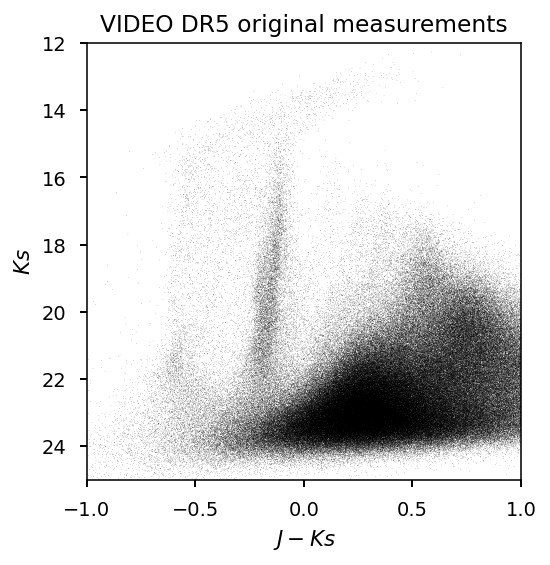

In [16]:
import matplotlib.pyplot as plt
#selected = v_flux['f_vista_y'] / v_flux['ferr_vista_y'] > 5
#selected &= v_flux['f_vista_ks'] / v_flux['ferr_vista_ks'] > 5
plt.style.use('seaborn-notebook')
plt.figure(1, figsize=(4, 4), dpi=140)
plt.scatter(video_flux['video_m_ap_vista_j'] - video_flux['video_m_ap_vista_ks'],
            video_flux['video_m_ap_vista_ks'],
            edgecolors='None', s=0.05, c='k', rasterized=True)
plt.xlim(-1, 1)
plt.ylim(25, 12)
plt.xlabel('$J-Ks$')
plt.ylabel('$Ks$')
plt.title('VIDEO DR5 original measurements')
plt.subplots_adjust(left=0.125, bottom=0.1)
plt.show()

In [17]:
#S/N cuts > 10 to mitigate Malquist bias
for c in video_flux.colnames:
    if '_ap_' in c:
        video_flux[c]=video_flux[c].astype('float64')
for b in ['z2','y2','j','h','ks']:
    mag=np.array(video_flux['video_merr_ap_vista_{}'.format(b)].copy())
    magErr=np.array(video_flux['video_merr_ap_vista_{}'.format(b)].copy())
                 
    mask=(
        (
        fluxFromABMag(mag)/
          fluxErrFromABMagErr(mag,magErr)
        )>10
    )
    print('Leaving {:.2f}% of objects in {} band'.format(100*np.sum(mask)/len(mask),b))
    video_flux['video_m_ap_vista_{}'.format(b)][~mask]=np.nan

Leaving 34.61% of objects in z2 band
Leaving 51.00% of objects in y2 band
Leaving 35.32% of objects in j band
Leaving 47.90% of objects in h band
Leaving 44.61% of objects in ks band


In [18]:
colour_cut=video_flux['video_m_ap_vista_j']-video_flux['video_m_ap_vista_ks'] <1
print('Leaving {:.2f}% of objects with J-Ks < 1'.format(100*np.sum(colour_cut)/len(mask)))
video_flux=video_flux[colour_cut]

Leaving 25.23% of objects with J-Ks < 1


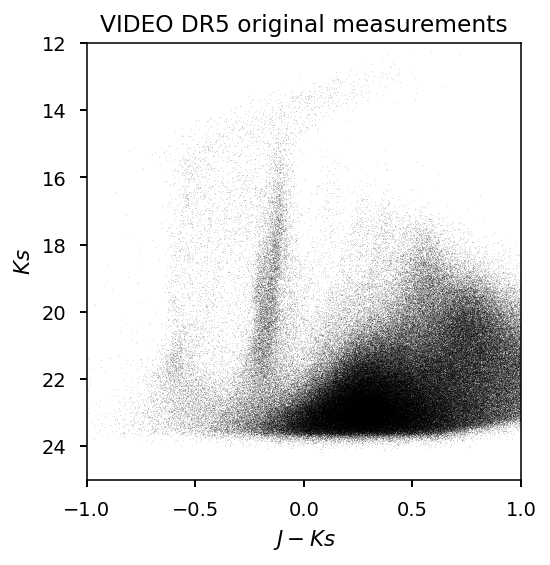

In [19]:
import matplotlib.pyplot as plt
#selected = v_flux['f_vista_y'] / v_flux['ferr_vista_y'] > 5
#selected &= v_flux['f_vista_ks'] / v_flux['ferr_vista_ks'] > 5
plt.style.use('seaborn-notebook')
plt.figure(1, figsize=(4, 4), dpi=140)
plt.scatter(video_flux['video_m_ap_vista_j'] - video_flux['video_m_ap_vista_ks'],
            video_flux['video_m_ap_vista_ks'],
            edgecolors='None', s=0.05, c='k', rasterized=True)
plt.xlim(-1, 1)
plt.ylim(25, 12)
plt.xlabel('$J-Ks$')
plt.ylabel('$Ks$')
plt.title('VIDEO DR5 original measurements')
plt.subplots_adjust(left=0.125, bottom=0.1)
plt.show()

In [20]:
print(len(catalogue),
      np.sum(catalogue['video_stellarity'] >= 0.01), 
      np.sum(catalogue['video_stellarity'] >= 0.1), 
      np.sum(catalogue['video_stellarity'] >= 0.5), 
      np.sum(catalogue['video_stellarity'] >= 0.9), )

1335572 1049498 578814 17781 7104


In [21]:
# Bands: Z,Y,J,H,K 


#This is from DR6 public reference (VEGA)
vhs_imported_columns = OrderedDict({
    'SOURCEID': "id",
    'RA': "ra",
    'DEC': "dec",
    'PSTAR':  "stellarity",

#     'ZAPERMAG3': "m_ap_vista_z2", 
#     'ZAPERMAG3ERR': "merr_ap_vista_z2",

#     'YAPERMAG3': "m_ap_vista_y2", 
#     'YAPERMAG3ERR': "merr_ap_vista_y2",

    'JAPERMAG3': "m_ap_vista_j", 
    'JAPERMAG3ERR': "merr_ap_vista_j",        

    'HAPERMAG3': "m_ap_vista_h", 
    'HAPERMAG3ERR': "merr_ap_vista_h",        

    'KSAPERMAG3': "m_ap_vista_ks", 
    'KSAPERMAG3ERR': "merr_ap_vista_ks",
})



vhs_catalogue = Table.read(VHS_CAT)[list(vhs_imported_columns)]
for column in vhs_imported_columns:
    new_col = 'vhs_' + vhs_imported_columns[column]
    vhs_catalogue[column].name = new_col
    vhs_catalogue[new_col].shape=(vhs_catalogue[new_col].shape[0],)
vhs_catalogue['vhs_ra'].unit = u.rad
vhs_catalogue['vhs_dec'].unit = u.rad

for col in vhs_catalogue.colnames:
    if col.startswith('vhs_m_ap'):
        print(col)
        mask = vhs_catalogue[col] <= 0
        mask |= vhs_catalogue[col] >  30
        vhs_catalogue[col][mask] = np.nan
        vhs_catalogue[col.replace('vhs_m', 'vhs_merr')][mask] = np.nan
        
        
        # Convert magnitude from Vega to AB
        before = np.nanmean(vhs_catalogue[col])
        vhs_catalogue[col] += vega_to_ab[col.split('_')[-1].replace('2', '')]
        print(col, vega_to_ab[col.split('_')[-1].replace('2', '')], np.nanmean(vhs_catalogue[col])-before)

vhs_flux = vhs_catalogue

vhs_m_ap_vista_j
vhs_m_ap_vista_j 0.916 0.9159908
vhs_m_ap_vista_h
vhs_m_ap_vista_h 1.385 1.3849964
vhs_m_ap_vista_ks
vhs_m_ap_vista_ks 1.816 1.8159943


In [22]:
video_flux[:5]

video_id,video_ra,video_dec,video_stellarity,video_m_ap_vista_z2,video_merr_ap_vista_z2,video_m_ap_vista_y2,video_merr_ap_vista_y2,video_m_ap_vista_j,video_merr_ap_vista_j,video_m_ap_vista_h,video_merr_ap_vista_h,video_m_ap_vista_ks,video_merr_ap_vista_ks
,rad,rad,,,,,,,,,,,
int64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
644245094433,0.6343632469428216,-0.09565690132363479,0.9998583,19.426816940307617,0.04518478736281395,nan,0.1314476877450943,19.361618041992188,0.08489499986171722,19.573095321655273,0.05296356976032257,19.93235206604004,0.0680559054017067
644245094436,0.6376032923116141,-0.09565623027519886,2.6672004e-05,20.93117332458496,0.07266055792570114,nan,0.22293919324874878,20.320581436157227,0.09119570255279541,20.049959182739258,0.05240407586097717,19.806243896484375,0.04884341359138489
644245094455,0.6373005533759349,-0.09564777311948322,5.2922104e-07,20.350433349609375,0.04614134132862091,20.165203094482422,0.0874694436788559,19.947032928466797,0.05647629499435425,19.806278228759766,0.040640730410814285,19.59259796142578,0.03643614053726196
644245094459,0.6457113577429142,-0.09564393412480045,5.2922104e-07,19.33020782470703,0.08073311299085617,19.076934814453125,0.10131658613681793,18.827632904052734,0.0637696385383606,18.523963928222656,0.044476039707660675,18.28879165649414,0.042981866747140884
644245094462,0.6395298867743962,-0.09564553999680492,5.2922104e-07,20.416105270385742,0.05278398469090462,nan,0.11322188377380371,19.93037223815918,0.06084759905934334,19.720455169677734,0.04097414016723633,19.4876651763916,0.03762898966670036


In [23]:
vhs_flux[:5]

vhs_id,vhs_ra,vhs_dec,vhs_stellarity,vhs_m_ap_vista_j,vhs_merr_ap_vista_j,vhs_m_ap_vista_h,vhs_merr_ap_vista_h,vhs_m_ap_vista_ks,vhs_merr_ap_vista_ks
,rad,rad,,,,,,,
int64,float64,float64,float32,float32,float32,float32,float32,float32,float32
472478420689,0.5313506138107422,0.02441398961306191,0.9,21.000256,0.25536814,nan,nan,nan,nan
472478420678,0.5346928341588668,0.02443321697338387,0.00017140902,20.061094,0.10981393,20.0059,0.16131267,19.713032,0.16325213
472478420677,0.5322687499760828,0.024426932772583718,0.9,20.851288,0.23619072,nan,nan,nan,nan
472478420674,0.5330263594316909,0.02443767892020007,0.00017140902,20.244732,0.13296393,19.94293,0.15068679,19.895264,0.19767918
472478420672,0.533468198257412,0.02443463076215464,0.9,20.81285,0.21036822,nan,nan,nan,nan


In [24]:
video_flux['ra']=video_flux['video_ra']
video_flux['dec']=video_flux['video_dec']
vhs_flux['vhs_ra_temp']=vhs_flux['vhs_ra']
vhs_flux['vhs_dec_temp']=vhs_flux['vhs_dec']
vhs_vid_merge=merge_catalogues(video_flux, vhs_flux, 'vhs_ra_temp', 'vhs_dec_temp', radius=0.6*u.arcsec)
for c in vhs_vid_merge.colnames:
    if str(vhs_vid_merge[c].dtype).startswith('float'):
        vhs_vid_merge[c].fill_value=np.nan
vhs_vid_merge=vhs_vid_merge.filled()

In [25]:
vhs_vid_merge[:5]

video_id,video_ra,video_dec,video_stellarity,video_m_ap_vista_z2,video_merr_ap_vista_z2,video_m_ap_vista_y2,video_merr_ap_vista_y2,video_m_ap_vista_j,video_merr_ap_vista_j,video_m_ap_vista_h,video_merr_ap_vista_h,video_m_ap_vista_ks,video_merr_ap_vista_ks,ra,dec,vhs_id,vhs_ra,vhs_dec,vhs_stellarity,vhs_m_ap_vista_j,vhs_merr_ap_vista_j,vhs_m_ap_vista_h,vhs_merr_ap_vista_h,vhs_m_ap_vista_ks,vhs_merr_ap_vista_ks
,rad,rad,,,,,,,,,,,,rad,rad,,rad,rad,,,,,,,
int64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float32,float32,float32,float32,float32,float32,float32
644245094433,0.6343632469428216,-0.09565690132363479,0.9998583,19.426816940307617,0.04518478736281395,nan,0.1314476877450943,19.361618041992188,0.08489499986171722,19.573095321655273,0.05296356976032257,19.93235206604004,0.0680559054017067,0.6343632469428216,-0.09565690132363479,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan
644245094492,0.6333332688483194,-0.09563783185200692,5.2922104e-07,20.242855072021484,0.06129921227693558,nan,0.13514114916324615,19.860010147094727,0.07959190756082535,19.737768173217773,0.05272737890481949,19.498573303222656,0.05353662744164467,0.6333332688483194,-0.09563783185200692,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan
644245094501,0.6415954615014829,-0.09563654995119676,0.008567858,nan,0.13590487837791443,nan,0.1864386647939682,21.909706115722656,0.1066024899482727,21.632871627807617,0.09127293527126312,21.29120445251465,0.07783854752779007,0.6415954615014829,-0.09563654995119676,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan
644245094536,0.6348287254291072,-0.09562815457809302,5.2922104e-07,21.547941207885742,0.06864973157644272,nan,0.14598996937274933,21.41341781616211,0.08499491959810257,21.40278434753418,0.07239276170730591,21.42510223388672,0.07997550070285797,0.6348287254291072,-0.09562815457809302,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan
644245094541,0.6339497424654646,-0.09562647042443327,0.77347136,21.37590789794922,0.07676469534635544,nan,0.13715001940727234,20.807239532470703,0.08034972846508026,20.837095260620117,0.06649967283010483,20.773046493530273,0.0703461766242981,0.6339497424654646,-0.09562647042443327,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [26]:
# v_flux['ra']=v_flux['video_ra']
# v_flux['dec']=v_flux['video_dec']
help_flux['help_ra_temp']=help_flux['help_ra']
help_flux['help_dec_temp']=help_flux['help_dec']
full_merge=merge_catalogues(vhs_vid_merge, help_flux, 'help_ra_temp', 'help_dec_temp', radius=0.6*u.arcsec)
for c in full_merge.colnames:
    if str(full_merge[c].dtype).startswith('float'):
        full_merge[c].fill_value=np.nan
full_merge=full_merge.filled()

In [27]:
full_merge[:5]

video_id,video_ra,video_dec,video_stellarity,video_m_ap_vista_z2,video_merr_ap_vista_z2,video_m_ap_vista_y2,video_merr_ap_vista_y2,video_m_ap_vista_j,video_merr_ap_vista_j,video_m_ap_vista_h,video_merr_ap_vista_h,video_m_ap_vista_ks,video_merr_ap_vista_ks,ra,dec,vhs_id,vhs_ra,vhs_dec,vhs_stellarity,vhs_m_ap_vista_j,vhs_merr_ap_vista_j,vhs_m_ap_vista_h,vhs_merr_ap_vista_h,vhs_m_ap_vista_ks,vhs_merr_ap_vista_ks,help_id,help_ra,help_dec,help_stellarity,help_m_ap_vista_z2,help_merr_ap_vista_z2,help_m_ap_vista_y2,help_merr_ap_vista_y2,help_m_ap_vista_j,help_merr_ap_vista_j,help_m_ap_vista_h,help_merr_ap_vista_h,help_m_ap_vista_ks,help_merr_ap_vista_ks
,rad,rad,,,,,,,,,,,,rad,rad,,rad,rad,,,,,,,,,rad,rad,,,,,,,,,,,
int64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
644245095767,0.6406367467934528,-0.09546754013555925,0.0057768743,nan,0.13143587112426758,nan,0.113546222448349,23.5538387298584,0.08422746509313583,23.517406463623047,0.09190040081739426,23.24309730529785,0.09243560582399368,0.6406367467934528,-0.09546754013555925,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
644245099060,0.6395728743247923,-0.09516923979475805,0.0057768743,24.1275634765625,0.087982676923275,23.88334083557129,0.08410417288541794,23.680797576904297,0.0769476592540741,23.839263916015625,0.09898117929697037,23.41887855529785,0.09434795379638672,0.6395728743247923,-0.09516923979475805,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
644245101098,0.6468944105828104,-0.09498396505458108,0.0057768743,22.354862213134766,0.03724363073706627,22.334875106811523,0.03641024976968765,22.27828598022461,0.035132139921188354,22.12016487121582,0.03558854013681412,22.59888458251953,0.05644197016954422,0.6468944105828104,-0.09498396505458108,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
644245101119,0.6459611760956507,-0.09498245849193229,0.0057768743,23.348878860473633,0.06302705407142639,23.168678283691406,0.05948542058467865,23.205263137817383,0.05887550488114357,23.272075653076172,0.07152662426233292,23.1350040435791,0.08152903616428375,0.6459611760956507,-0.09498245849193229,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
644245101476,0.6486375221568222,-0.09494593752447877,0.0057768743,23.195926666259766,0.08025291562080383,23.05470848083496,0.07772422581911087,22.80811309814453,0.06708318740129471,22.45379638671875,0.0634818747639656,22.850744247436523,0.09427474439144135,0.6486375221568222,-0.09494593752447877,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


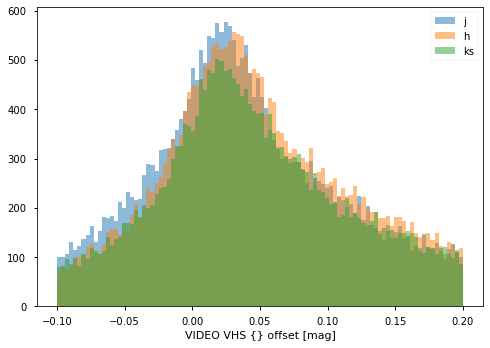

In [28]:
bins=100
r=[-0.1,0.2]
for b in ['j','h','ks']:
    plt.hist(
        full_merge['vhs_m_ap_vista_'+b]-full_merge['video_m_ap_vista_'+b],
        bins=bins,range=r,alpha=0.5,label=b)
    plt.xlabel('VIDEO VHS {} offset [mag]')
plt.legend()

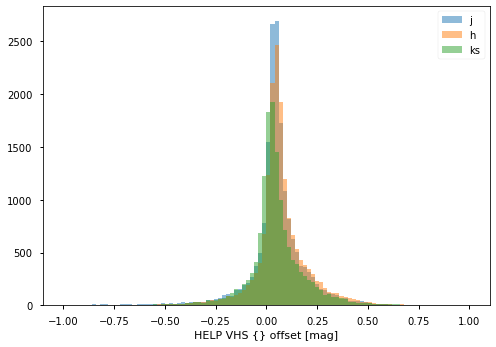

In [29]:
bins=100
r=[-1,1]
for b in ['j','h','ks']:
    m=full_merge['help_stellarity']>0.9
    plt.hist(
        full_merge[m]['vhs_m_ap_vista_'+b]-full_merge[m]['help_m_ap_vista_'+b],
        bins=bins,range=r,alpha=0.5,label=b)
    plt.xlabel('HELP VHS {} offset [mag]')
plt.legend()

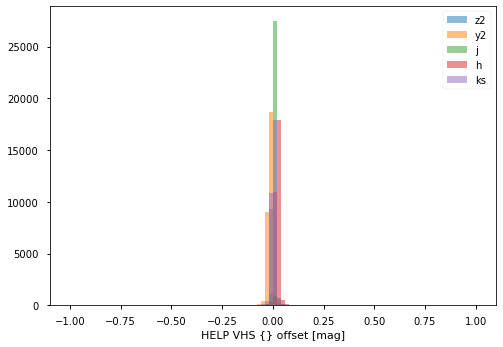

In [30]:
bins=100
r=[-1,1]
for b in ['z2','y2','j','h','ks']:
    m=full_merge['help_stellarity']>0.9
    plt.hist(
        full_merge[m]['video_m_ap_vista_'+b]-full_merge[m]['help_m_ap_vista_'+b],
        bins=bins,range=r,alpha=0.5,label=b)
    plt.xlabel('HELP VHS {} offset [mag]')
plt.legend()

(-1.0, 1.0)

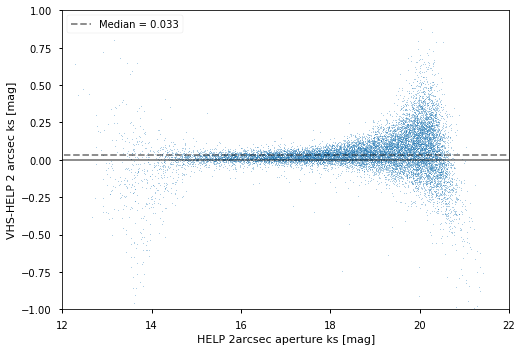

In [31]:
m=full_merge['help_stellarity']>0.9
plt.scatter(full_merge[m]['help_m_ap_vista_'+b],full_merge[m]['vhs_m_ap_vista_'+b]-full_merge[m]['help_m_ap_vista_'+b],s=0.1)
plt.plot([0,30],[0,0],c='k',alpha=0.5)
median=np.nanmedian(full_merge[m]['vhs_m_ap_vista_'+b]-full_merge[m]['help_m_ap_vista_'+b])
plt.plot([0,30],[median,median],c='k',alpha=0.5,linestyle='--',label='Median = {:.3f}'.format(median))
plt.xlabel('HELP 2arcsec aperture {} [mag]'.format(b))
plt.ylabel('VHS-HELP 2 arcsec {} [mag]'.format(b))
plt.legend()
plt.xlim([12,22])
plt.ylim([-1,1])

(-0.4, 0.4)

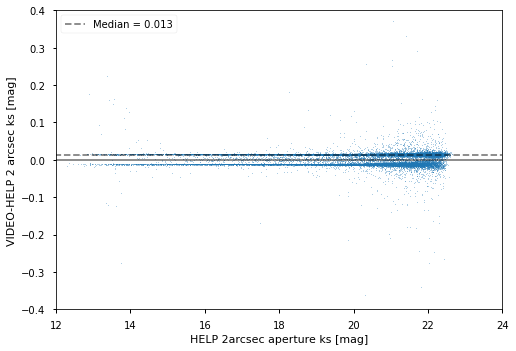

In [32]:
m=full_merge['help_stellarity']>0.9
b='ks'
plt.scatter(full_merge[m]['help_m_ap_vista_'+b],full_merge[m]['video_m_ap_vista_'+b]-full_merge[m]['help_m_ap_vista_'+b],s=0.1)
plt.plot([0,30],[0,0],c='k',alpha=0.5)
median=np.nanmedian(full_merge[m]['video_m_ap_vista_'+b]-full_merge[m]['help_m_ap_vista_'+b])
plt.plot([0,30],[median,median],c='k',alpha=0.5,linestyle='--',label='Median = {:.3f}'.format(median))
plt.xlabel('HELP 2arcsec aperture {} [mag]'.format(b))
plt.ylabel('VIDEO-HELP 2 arcsec {} [mag]'.format(b))
plt.legend()
plt.xlim([12,24])
plt.ylim([-0.4,0.4])

(-0.4, 0.4)

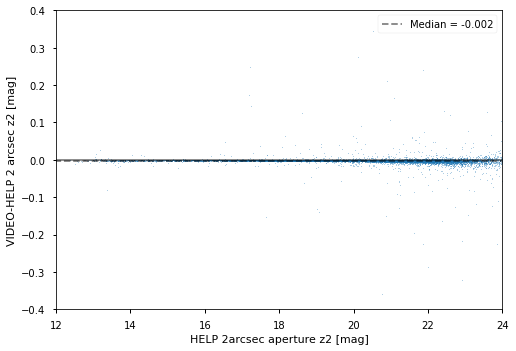

In [33]:
m=full_merge['help_stellarity']>0.9
b='z2'
plt.scatter(full_merge[m]['help_m_ap_vista_'+b],full_merge[m]['video_m_ap_vista_'+b]-full_merge[m]['help_m_ap_vista_'+b],s=0.1)
plt.plot([0,30],[0,0],c='k',alpha=0.5)
median=np.nanmedian(full_merge[m]['video_m_ap_vista_'+b]-full_merge[m]['help_m_ap_vista_'+b])
plt.plot([0,30],[median,median],c='k',alpha=0.5,linestyle='--',label='Median = {:.3f}'.format(median))
plt.xlabel('HELP 2arcsec aperture {} [mag]'.format(b))
plt.ylabel('VIDEO-HELP 2 arcsec {} [mag]'.format(b))
plt.legend()
plt.xlim([12,24])
plt.ylim([-0.4,0.4])

(-0.5, 0.5)

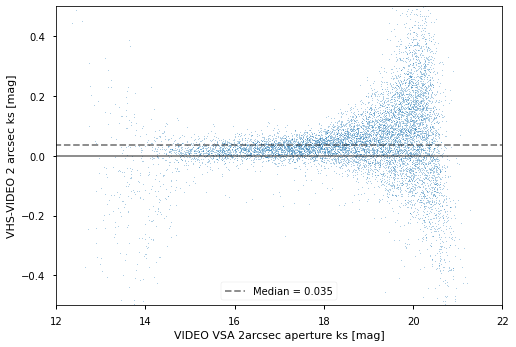

In [34]:
m=full_merge['help_stellarity']>0.9
b='ks'
plt.scatter(full_merge[m]['video_m_ap_vista_'+b],full_merge[m]['vhs_m_ap_vista_'+b]-full_merge[m]['video_m_ap_vista_'+b],s=0.1)
plt.plot([0,30],[0,0],c='k',alpha=0.5)
median=np.nanmedian(full_merge[m]['vhs_m_ap_vista_'+b]-full_merge[m]['video_m_ap_vista_'+b])
plt.plot([0,30],[median,median],c='k',alpha=0.5,linestyle='--',label='Median = {:.3f}'.format(median))
plt.xlabel('VIDEO VSA 2arcsec aperture {} [mag]'.format(b))
plt.ylabel('VHS-VIDEO 2 arcsec {} [mag]'.format(b))
plt.legend()
plt.xlim([12,22])
plt.ylim([-0.5,0.5])

In [35]:
vhs_area=(
    np.nanmax(vhs_vid_merge['vhs_ra'])-np.nanmin(vhs_vid_merge['vhs_ra'])
)*(
    np.nanmax(vhs_vid_merge['vhs_dec'])-np.nanmin(vhs_vid_merge['vhs_dec'])
)
vid_area=(
    np.nanmax(vhs_vid_merge['video_ra'])-np.nanmin(vhs_vid_merge['video_ra'])
)*(
    np.nanmax(vhs_vid_merge['video_dec'])-np.nanmin(vhs_vid_merge['video_dec'])
)
vhs_area/vid_area

36.937510684747224

In [36]:
print(
    np.nanmax(vhs_vid_merge['vhs_ra']),
    np.nanmin(vhs_vid_merge['vhs_ra']),
    np.nanmax(vhs_vid_merge['video_ra']),
    np.nanmin(vhs_vid_merge['video_ra']),
    np.nanmax(vhs_vid_merge['vhs_dec']),
    np.nanmin(vhs_vid_merge['vhs_dec']),
    np.nanmax(vhs_vid_merge['video_dec']),
    np.nanmin(vhs_vid_merge['video_dec']),
)

0.7243113120574444 0.4799655967714187 0.6490145865492528 0.609381736645414 0.02515257824207536 -0.13962626749089257 -0.06957890424861239 -0.09708210620134984


In [37]:
print('Total objects:',len(vhs_vid_merge))
print('Objects without VIDEO detection:',np.sum(np.isnan(vhs_vid_merge['video_ra'])))
print('Objects without VHS detection:',np.sum(np.isnan(vhs_vid_merge['vhs_ra'])))
print('Objects in both:',np.sum((~np.isnan(vhs_vid_merge['vhs_ra']))&(~np.isnan(vhs_vid_merge['video_ra']))))
print('Total objects:',len(vhs_vid_merge))

Total objects: 2592267
Objects without VIDEO detection: 2255296
Objects without VHS detection: 296468
Objects in both: 40503
Total objects: 2592267


In [38]:

#Keep only VIDEO detected objects
vhs_vid_merge=vhs_vid_merge[~np.isnan(vhs_vid_merge['video_ra'])]
# replace empty video JHKs with VHS
for b in ['j','h','ks']:
    mask=np.isnan(vhs_vid_merge['video_m_ap_vista_'+b])
    vhs_vid_merge[mask]['video_m_ap_vista_'+b]=vhs_vid_merge[mask]['vhs_m_ap_vista_'+b]
    vhs_vid_merge[mask]['video_merr_ap_vista_'+b]=vhs_vid_merge[mask]['vhs_merr_ap_vista_'+b]
#remove vhs columns
for c in vhs_vid_merge.colnames:
    if c.startswith('vhs_'):
        vhs_vid_merge.remove_column(c)


Text(0.5, 0, 'VIDEO DR5 VSA PSTAR')

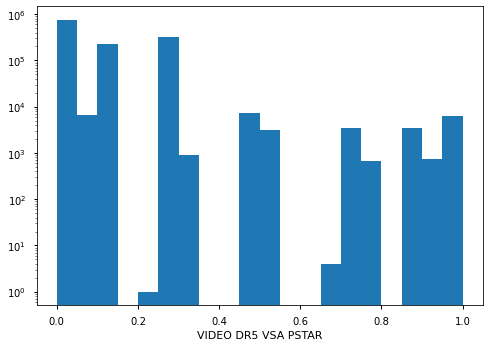

In [39]:
plt.hist(catalogue['video_stellarity'],bins=20 )
plt.yscale('log')
plt.xlabel('VIDEO DR5 VSA PSTAR')

Text(0.5, 0, 'HELP private VIDEO K_CLASS_STAR')

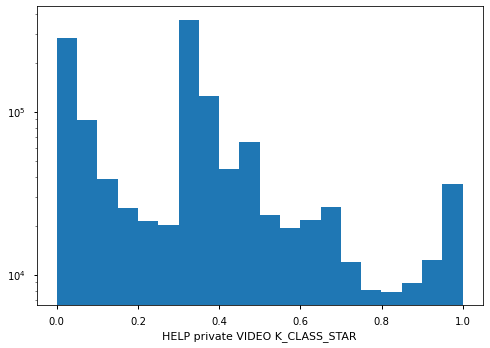

In [40]:
plt.hist(help_cat['K_CLASS_STAR'],bins=20 )
plt.yscale('log')
plt.xlabel('HELP private VIDEO K_CLASS_STAR')

In [41]:
for key in vega_to_ab:
    print(key,np.sum(np.isnan(video_flux[
        'video_m_ap_vista_{}'.format(
        key.replace('z','z2').replace('y','y2'))
    ])))

z 183644
y 18977
j 0
h 6667
ks 0


Text(0, 0.5, 'Dec [rad]')

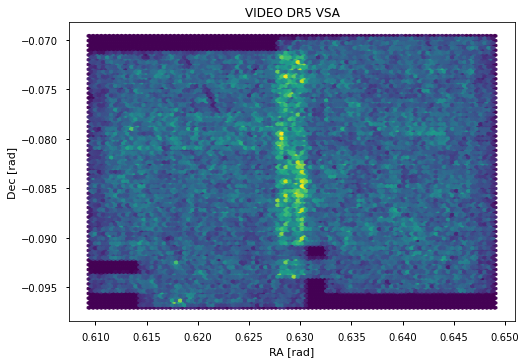

In [42]:
plt.hexbin(video_flux['video_ra'],video_flux['video_dec'],rasterized=True)
plt.title('VIDEO DR5 VSA')
plt.xlabel('RA [rad]')
plt.ylabel('Dec [rad]')

Text(0, 0.5, 'Dec [rad]')

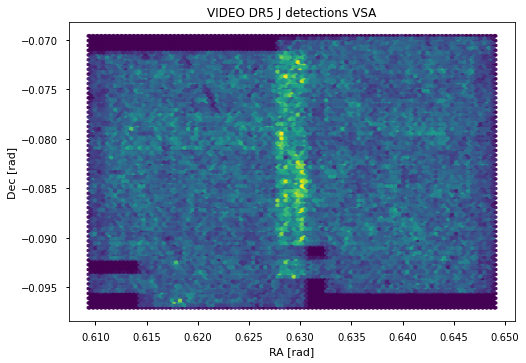

In [43]:
tempMask=~np.isnan(video_flux['video_m_ap_vista_j'])
plt.hexbin(video_flux[tempMask]['video_ra'],video_flux[tempMask]['video_dec'],rasterized=True)
plt.title('VIDEO DR5 J detections VSA')
plt.xlabel('RA [rad]')
plt.ylabel('Dec [rad]')

There are no J fluxes in one of the pointings

In [44]:
np.sum(~np.isnan(full_merge['vhs_m_ap_vista_j'])),np.sum(~np.isnan(full_merge['video_m_ap_vista_j'])),np.sum(~np.isnan(full_merge['help_m_ap_vista_j']))

(1873379, 336971, 1253838)

Text(0, 0.5, 'Dec [rad]')

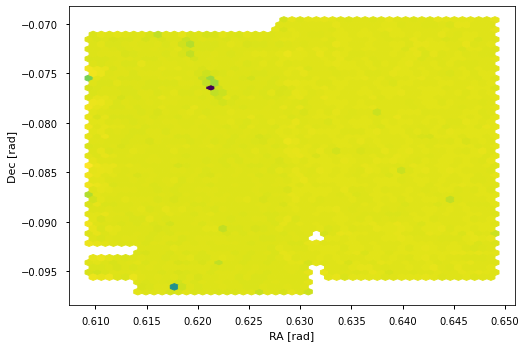

In [45]:
tempMask=~np.isnan(full_merge['help_m_ap_vista_j'])
plt.hexbin(full_merge[tempMask]['video_ra'],full_merge[tempMask]['video_dec'],
           C=full_merge[tempMask]['video_m_ap_vista_j']-full_merge[tempMask]['help_m_ap_vista_j'],
           gridsize=50)

plt.xlabel('RA [rad]')
plt.ylabel('Dec [rad]')

In [46]:
np.sum(~np.isnan(vhs_vid_merge['video_m_ap_vista_j']))

336971

Text(0, 0.5, 'Dec [deg]')

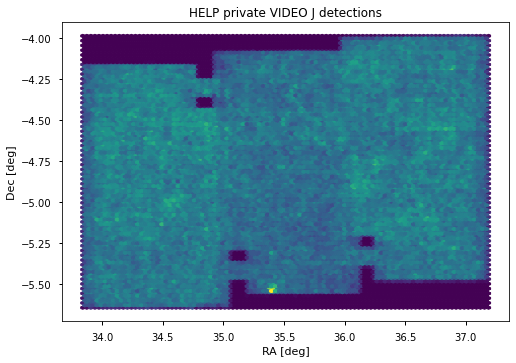

In [47]:
tempMask=(help_cat['J_MAG_APER_3']>10) & (help_cat['J_MAG_APER_3']<30)
plt.hexbin(help_cat[tempMask]['ALPHA_J2000'],help_cat[tempMask]['DELTA_J2000'],rasterized=True)
plt.title('HELP private VIDEO J detections')
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')

In [48]:
np.sum(np.isnan(video_flux['video_m_ap_vista_j']))

0

In [49]:
print(np.sum(catalogue['video_stellarity'] >= 0.9),np.sum(help_cat['K_CLASS_STAR'] >= 0.9))

7104 48616


In [50]:
print(len(catalogue),len(help_cat))

1335572 1253838


In [51]:
video_flux[:5]

video_id,video_ra,video_dec,video_stellarity,video_m_ap_vista_z2,video_merr_ap_vista_z2,video_m_ap_vista_y2,video_merr_ap_vista_y2,video_m_ap_vista_j,video_merr_ap_vista_j,video_m_ap_vista_h,video_merr_ap_vista_h,video_m_ap_vista_ks,video_merr_ap_vista_ks,ra,dec
,rad,rad,,,,,,,,,,,,rad,rad
int64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
644245094433,0.6343632469428216,-0.09565690132363479,0.9998583,19.426816940307617,0.04518478736281395,nan,0.1314476877450943,19.361618041992188,0.08489499986171722,19.573095321655273,0.05296356976032257,19.93235206604004,0.0680559054017067,0.6343632469428216,-0.09565690132363479
644245094436,0.6376032923116141,-0.09565623027519886,2.6672004e-05,20.93117332458496,0.07266055792570114,nan,0.22293919324874878,20.320581436157227,0.09119570255279541,20.049959182739258,0.05240407586097717,19.806243896484375,0.04884341359138489,0.6376032923116141,-0.09565623027519886
644245094455,0.6373005533759349,-0.09564777311948322,5.2922104e-07,20.350433349609375,0.04614134132862091,20.165203094482422,0.0874694436788559,19.947032928466797,0.05647629499435425,19.806278228759766,0.040640730410814285,19.59259796142578,0.03643614053726196,0.6373005533759349,-0.09564777311948322
644245094459,0.6457113577429142,-0.09564393412480045,5.2922104e-07,19.33020782470703,0.08073311299085617,19.076934814453125,0.10131658613681793,18.827632904052734,0.0637696385383606,18.523963928222656,0.044476039707660675,18.28879165649414,0.042981866747140884,0.6457113577429142,-0.09564393412480045
644245094462,0.6395298867743962,-0.09564553999680492,5.2922104e-07,20.416105270385742,0.05278398469090462,nan,0.11322188377380371,19.93037223815918,0.06084759905934334,19.720455169677734,0.04097414016723633,19.4876651763916,0.03762898966670036,0.6395298867743962,-0.09564553999680492


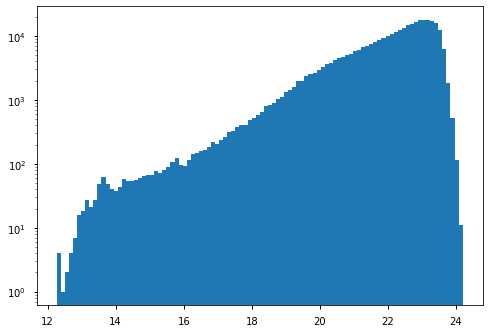

In [52]:
plt.hist(video_flux['video_m_ap_vista_ks'], bins=100)
plt.yscale('log')

In [53]:
np.sum(~np.isnan(video_flux['video_m_ap_vista_ks']))

336971

In [54]:
import astropy.units as u

In [55]:
import astropy.units as u
for col in video_flux.colnames:
    if col.startswith('f'):
        video_flux[col] /= 1.E6
        video_flux[col].unit = u.Jansky


In [56]:
video_flux['video_ra'].unit = u.rad
video_flux['video_dec'].unit = u.rad
video_flux['video_ra'].convert_unit_to(u.rad)
video_flux['video_dec'].convert_unit_to(u.rad)
#v_flux['ra'].name = 'v_ra'
#v_flux['dec'].name = 'v_dec'

In [57]:
r_cat = Table.read(EX_CAT)

In [58]:
#Delete old folder
!rm -r ./data/ref_cats_video/
!mkdir -p ./data/ref_cats_video/

In [59]:
#USE HELP cat
vista_flux=help_flux.copy()
for c in vista_flux.colnames:
    vista_flux[c].name = c.replace('help','video')
vista_flux=vista_flux[vista_flux['video_stellarity']>0.9]

In [60]:
#USE CATALOGUE with VHS replacements
# v_flux=vhs_vid_merge
# v_flux.remove_columns(['ra','dec'])

In [61]:
#VIDEO REF CAT
n_video=0
n_tot=0
total_cat=Table()
for c in ps_refcats:
    r_cat = Table.read("../dmu0/dmu0_PanStarrs/data/ps1_pv3_3pi_20170110/{}.fits".format(c))
    r_cat['coord_ra'].name = 'ra'
    r_cat['coord_dec'].name = 'dec'
    merge = merge_catalogues(r_cat, vista_flux, 'video_ra', 'video_dec', radius=0.8*u.arcsec)
    merge=clean_table(merge)
    has_both  = (
        (merge['g_flux'] >0.)
        # &(merge['video_m_ap_vista_ks']>0.) #Take all panstarrs objects
    )

    merge = merge[has_both]
    
    if np.sum(~np.isnan(merge['video_m_ap_vista_ks'])) == 0:
        #print('No VIDEO objects in {}'.format(c))
        continue
    
    
    merge['ra'].name = 'coord_ra'
    merge['dec'].name = 'coord_dec'
    #convert rad to degs?
    merge['coord_ra'] = (180./np.pi)*merge['coord_ra']
    merge['coord_ra'].unit = u.deg
    merge['coord_dec'] = (180./np.pi)*merge['coord_dec']
    merge['coord_dec'].unit = u.deg
    
    removePm=False
    if removePm:
        merge['pm_ra']=0
        merge['pm_dec']=0
        merge['pm_ra_err']=0
        merge['pm_dec_err']=0
    else:
        merge['pm_ra'].unit=u.marcsec/u.year
        merge['pm_dec'].unit=u.marcsec/u.year
        merge['pm_ra_err'].unit=u.marcsec/u.year
        merge['pm_dec_err'].unit=u.marcsec/u.year
        merge['pm_ra'].convert_unit_to(u.rad/u.year)
        merge['pm_dec'].convert_unit_to(u.rad/u.year)
        merge['pm_ra_err'].convert_unit_to(u.rad/u.year)
        merge['pm_dec_err'].convert_unit_to(u.rad/u.year)
    
    merge['pm_ra_err'].name = 'pm_raErr'
    merge['pm_dec_err'].name = 'pm_decErr'
    try:
        merge['coord_raErr'] = (180./np.pi)*merge['coord_ra_err']
        merge['coord_raErr'].unit = u.deg
        merge['coord_decErr'] = (180./np.pi)*merge['coord_dec_err']
        merge['coord_decErr'].unit = u.deg
        merge.remove_columns['coord_ra_err', 'coord_dec_err']
    except:
        merge['coord_raErr'] = (180./np.pi)*merge['coord_raErr']
        merge['coord_raErr'].unit = u.deg
        merge['coord_decErr'] = (180./np.pi)*merge['coord_decErr']
        merge['coord_decErr'].unit = u.deg
    #flags col only in James Mulaney 19 cut cat
    #merge['flags'].format = '1X'
    merge['epoch']=merge['epoch'].astype(float)
    merge['epoch'] = Time(merge['epoch'],format='unix').mjd
    #merge[has_both].write('./data/refcats/{}.fits'.format(c), overwrite=True)
    
    for col in merge.colnames:
        #go through every flux column and convert to mags and rename
        if col.endswith('_flux'):
            err_col = col + 'Sigma'
            mag = abMagFromFlux(merge[col])
            mag_err = abMagErrFromFluxErr(merge[err_col],merge[col])
            merge[col] = mag
            merge[col].name = col[:-5]
            merge[err_col] = mag_err
            merge[err_col].name = err_col.replace('fluxSigma','err')
        #Go through every video mag col and rename
        if col.startswith('video_m_'):
            #Leave just band and replace z/y with z2/y2
            merge[col].name = col.split('_')[-1]
           
            merge[col.replace('video_m_', 'video_merr_')].name =  col.split('_')[-1] + '_err'
    merge.remove_columns(['video_stellarity', 'video_id'])
    merge.write('./data/ref_cats_video/{}.fits'.format(c), overwrite=True)
    total_cat=vstack([total_cat,merge])
    print("Shard {} has {} objects and {} VIDEO mags.".format(c, len(merge), np.sum(~np.isnan(merge['ks']))))
    n_video+=np.sum(~np.isnan(merge['ks']))
    n_tot+=len(merge)

Shard 133200 has 12877 objects and 1076 VIDEO mags.
Shard 133201 has 12581 objects and 2297 VIDEO mags.
Shard 133202 has 14150 objects and 2012 VIDEO mags.
Shard 133203 has 13422 objects and 2298 VIDEO mags.
Shard 133206 has 13264 objects and 757 VIDEO mags.
Shard 133209 has 11969 objects and 553 VIDEO mags.
Shard 133213 has 14287 objects and 1685 VIDEO mags.
Shard 133214 has 12922 objects and 2054 VIDEO mags.
Shard 133215 has 12812 objects and 1120 VIDEO mags.
Shard 133312 has 14458 objects and 168 VIDEO mags.
Shard 133313 has 12464 objects and 30 VIDEO mags.
Shard 133314 has 12578 objects and 1706 VIDEO mags.
Shard 133315 has 11994 objects and 927 VIDEO mags.
Shard 133317 has 12708 objects and 238 VIDEO mags.
Shard 133318 has 11838 objects and 32 VIDEO mags.
Shard 133319 has 12184 objects and 185 VIDEO mags.
Shard 133321 has 12893 objects and 1452 VIDEO mags.
Shard 133322 has 12242 objects and 714 VIDEO mags.
Shard 133323 has 12732 objects and 940 VIDEO mags.
Shard 133324 has 13102 o

In [62]:
n_video,n_tot

(33622, 435888)

In [63]:
len(total_cat)

435888

In [64]:
Time(total_cat['epoch'],format='unix').mjd

array([40587.65465871, 40587.6546591 , 40587.65280768, ...,
       40587.64619283, 40587.64929395, 40587.65472805])

In [65]:
total_cat[:5]

id,coord_ra,coord_dec,parent,g,r,i,z,y,i_err,y_err,r_err,z_err,g_err,coord_ra_err,coord_dec_err,epoch,pm_ra,pm_dec,pm_raErr,pm_decErr,footprint,z2,z2_err,y2,y2_err,j,j_err,h,h_err,ks,ks_err,video_ra_temp,video_dec_temp,coord_raErr,coord_decErr
,deg,deg,,,,,,,,,,,,,,,rad / yr,rad / yr,rad / yr,rad / yr,,,,,,,,,,,,rad,rad,deg,deg
int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32
101240348703435595,34.87036975815662,-5.629017440818079,0,22.84944052676361,22.4914670725002,22.39608519557794,22.757086755436085,21.32785086676439,0.1606630921581302,0.21222193722660687,0.13476184717552087,0.19612475166130405,0.16741811180528593,0.0,0.0,56562.51259259259,0.0,0.0,0.0,0.0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0
101240348719679131,34.872000500259766,-5.6260778101412985,0,23.184826381773323,23.08681973437381,22.62273782291056,23.0104303728167,20.56244854319749,0.3220554294531736,0.20988879044150155,0.5020276795463325,0.08328634183787527,0.11316483615715915,0.0,0.0,56562.54666666667,0.0,0.0,0.0,0.0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0
101240348725326683,34.87244485244289,-5.6282251083520904,0,22.66570809143991,22.44191414089089,22.43628268227504,22.26743693321702,21.631753428728295,0.0769716442998877,0.8861560079770756,0.11956874577913397,0.11018122593594812,0.18553137263225183,0.0,0.0,56402.583703703705,0.0,0.0,0.0,0.0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0
101220348728797983,34.87293013703126,-5.643699732046367,0,23.206315040142886,21.613636020356253,20.94146485382259,20.748910842583385,20.38352723907499,0.03108193830196016,0.0724149187422211,0.08042308304672052,0.04306769529453557,0.36502200451003547,0.0,0.0,56369.09333333333,-3.4612303e-11,-3.7397526e-11,7.011304e-11,6.979133e-11,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0
101220348739597084,34.87398615001206,-5.644378751618471,0,22.774808414089264,21.46113159738162,19.76586692425524,18.961333057134826,18.59359977313514,0.009793262080674723,0.008706714569025956,0.05192713968125531,0.015864659220396253,0.15705289932506117,0.0,0.0,57004.90814814815,7.832675e-11,2.4269522e-11,1.95988e-11,1.292778e-11,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0


In [66]:
for b in ['z2','y2','j','h','ks']:
    print(b, np.sum(~np.isnan(total_cat[b])))

z2 33622
y2 33622
j 33622
h 33622
ks 33622
